In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pickle

%load_ext autoreload
%autoreload 2
# Bring utils package onto the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import DataLoader, RunModel

In [3]:
def train_dataset(filename, label):
    data_loader = DataLoader()
    data_loader.load_data(f"data/{filename}.csv")
    X_train, X_test, y_train, y_test = data_loader.get_data_split(label=label)
    print(f'Training data: {X_train.shape}')
    print(f'Testing data: {X_test.shape}')
    
    rf = RunModel()
    rf.run_model(X_train, X_test, y_train)
    rf.model_performance(X_test , y_test)
    return rf, X_train, X_test, y_train, y_test

### Single Modalities

In [4]:
print("MRI Data - AD TO NC")
mri_rf, mri_X_train, mri_X_test, mri_y_train, mri_y_test = train_dataset('sMRI_AD_NC', 'AD')
mri_rf.save_model('models/sMRI_RF', mri_X_train, mri_X_test, mri_y_train, mri_y_test)
print(f"Accuracy: {mri_rf.accuracy}. F1-Score: {mri_rf.f1}. AUC: {mri_rf.auc}")

MRI Data - AD TO NC
Training data: (3567, 35)
Testing data: (892, 35)
Saved.
Accuracy: 0.8452914798206278. F1-Score: 0.5576923076923077. AUC: 0.883378317588844


In [9]:
print("Neuro Data - AD TO NC")
neuro_rf, neuro_X_train, neuro_X_test, neuro_y_train, neuro_y_test = train_dataset('Neuro_AD_NC', 'AD')
neuro_rf.save_model('models/neuro_RF', neuro_X_train, neuro_X_test, neuro_y_train, neuro_y_test)
print(f"Accuracy: {neuro_rf.accuracy}. F1-Score: {neuro_rf.f1}. AUC: {neuro_rf.auc}")

Neuro Data - AD TO NC
Training data: (3567, 3)
Testing data: (892, 3)
Saved.
Accuracy: 0.7399103139013453. F1-Score: 0.18309859154929578. AUC: 0.5266194331983807


### Multimodal Dataset (Early Fusion)

In [11]:
print("Multimodal Data - AD TO NC")
multimodal_rf, X_train, X_test, y_train, y_test = train_dataset('ADNI_AD_NC', 'AD')
multimodal_rf.save_model('models/ADNI_AD_NC', X_train, X_test, y_train, y_test)
print(f"Accuracy: {multimodal_rf.accuracy}. F1-Score: {multimodal_rf.f1}. AUC: {multimodal_rf.auc}")

Multimodal Data - AD TO NC
Training data: (1892, 40)
Testing data: (474, 40)
Saved.
Accuracy: 0.9641350210970464. F1-Score: 0.9594272076372315. AUC: 0.996947113226183


In [14]:
X_train.head()

,MCI,Age,MMSE,ADAS11,ADAS13,TotalICVolume,3rdVentricle,4thVentricle,RightAccumbensArea,LeftAccumbensArea,...,LeftPutamen,RightThalamusProper,LeftThalamusProper,RightVentralDC,LeftVentralDC,LeftBasalForebrain,RightBasalForebrain,Right Cortex,Left Cortex,Cerebellar Vermis
1195,0,74.307529,25.0,12.67,22.67,1214750.869,2214.658120,2238.553505,241.279950,203.745164,...,3685.070155,7298.454155,7468.047950,4572.794283,4643.317388,478.013433,436.989497,260663.6536,257481.8668,8818.877328
1119,0,90.634908,27.0,4.00,9.00,1214750.869,3874.994922,2410.256772,272.174796,368.337819,...,4137.340620,6801.228633,6755.325735,4506.894410,4832.571920,355.266133,344.322396,230960.2763,223433.8224,11251.276410
2145,0,79.100000,22.0,33.00,45.00,1214750.869,1509.465577,2094.603084,277.028150,258.109154,...,3586.501023,6974.352592,7039.217720,4633.802565,4654.072917,274.325436,413.515190,241353.6809,224360.3688,10525.718340
849,0,80.300000,28.0,4.67,11.67,1214750.869,3621.672065,4207.432032,32.264704,0.900791,...,577.898516,5120.015433,5839.174391,3909.352026,4201.290273,178.684223,385.292974,199395.0511,204500.1625,9469.526808
1484,0,71.602053,30.0,1.00,3.00,1214750.869,1507.535260,2710.121118,417.944046,463.161352,...,4712.615707,6596.086677,6904.147807,4377.813159,4508.311277,460.049624,358.432237,260492.6216,263398.0037,10297.196110


#### Hyperparameter Tuning - Grid Search

In [55]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at each split
max_features = ['auto', 'sqrt']
# Max depth in tree
max_depth = [None, 2, 4]
# Min num samples to split a node
min_samples_split = [2, 5]
# Min num samples at each leaf node
min_samples_leaf = [1, 2]
# Choice to boostrap for sample selection
bootstrap = [True, False]

In [56]:
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap
            }
print(param_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [None, 2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [57]:
rf_gr = GridSearchCV(estimator=multimodal_rf.model, param_grid=param_grid, cv=10, verbose=2, n_jobs=4)
rf_gr.fit(X_train, y_train)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [None, 2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             verbose=2)

In [59]:
rf_gr_pred = rf_gr.predict(X_test)
accuracy = accuracy_score(y_test, rf_gr_pred)
f1 = f1_score(y_test, rf_gr_pred)
rf_gr_probs = rf_gr.predict_proba(X_test)
rf_gr_probs = rf_gr_probs[:, 1]
rf_gr_auc = roc_auc_score(y_test, rf_gr_probs)
print(f"Accuracy: {accuracy}. F1-Score: {f1}. AUC: {rf_gr_auc}")

Accuracy: 0.9662447257383966. F1-Score: 0.9619047619047618. AUC: 0.9951064020831463


In [51]:
rf_gr.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 17}

## Performance

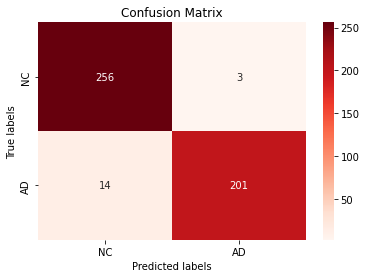

In [15]:
cm = confusion_matrix(y_test, multimodal_rf.prediction)
ax= plt.subplot()
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Reds');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NC', 'AD']); ax.yaxis.set_ticklabels(['NC', 'AD']);

plt.savefig('plots/ADNC-ConfusionMatrix.png')


#### ROC curve
Plots the **False Positive Rate (FPR)** on the x-axis and the **True Positive Rate (TPR)** on the y-axis.

In [30]:
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))

Random (chance) Prediction: AUROC = 0.500


In [61]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, multimodal_rf.probs)
mri_fpr, mri_tpr, _ = roc_curve(mri_y_test, mri_rf.probs)
neuro_fpr, neuro_tpr, _ = roc_curve(neuro_y_test, neuro_rf.probs)

rf_gr_fpr, rf_gr_tpr, _ = roc_curve(y_test, rf_gr_probs)

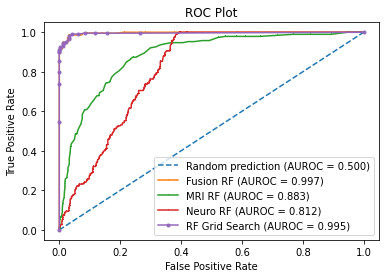

In [65]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker=',', label='Fusion RF (AUROC = %0.3f)' % multimodal_rf.auc)
plt.plot(mri_fpr, mri_tpr, marker=',', label='MRI RF (AUROC = %0.3f)' % mri_rf.auc)
plt.plot(neuro_fpr, neuro_tpr, marker=',', label='Neuro RF (AUROC = %0.3f)' % neuro_rf.auc)

plt.plot(rf_gr_fpr, rf_gr_tpr, marker='.', label='RF Grid Search (AUROC = %0.3f)' % rf_gr_auc)


plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('plots/ADNC-ROCCurve.png')
plt.show()